# Linear Regression Project Pt. 3: Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

nyc = pd.read_csv('nyc.csv')
nyc.head()

,PRICE,TITLE,LOCATION,BR,BA,SQFT,APP_FEE,BROK_FEE,WD,PARKING,PETS,BOROUGH
0,2750.0,►►STUNNING 3 BEDROOM W/ QUEEN-SIZED ROOMS IN B...,BUSHWICK,3.0,1.0,NaN,True,True,on site,none,True,BROOKLYN
1,2950.0,►►1 BEDROOM IN NEW LUXURY BLDG IN PARK SLOPE W...,PARK SLOPE,1.0,1.0,NaN,True,True,on site,none,True,BROOKLYN
2,2700.0,✸3 bedroom washer dryer ready for move in✸,BEDFORD STUYVESANT,3.0,1.0,NaN,False,False,on site,none,False,BROOKLYN
3,2500.0,New Gut Renovated 3 Bedroom+Laundry+Hardwood Fls,BROOKLYN,3.0,1.0,900.0,True,True,on site,none,True,BROOKLYN
4,1999.0,2 FULL SIZED BEDROOMS/ 3 MINUTE WALK TO Q TRAIN,PROSPECT LEFFERTS GARDEN,2.0,1.0,700.0,True,True,none,none,True,BROOKLYN


In [2]:
nyc = nyc.drop(columns=['TITLE','LOCATION'], axis=1)

In [3]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4609 entries, 0 to 4608
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PRICE     4609 non-null   float64
 1   BR        4609 non-null   float64
 2   BA        4609 non-null   float64
 3   SQFT      969 non-null    float64
 4   APP_FEE   4609 non-null   bool   
 5   BROK_FEE  4609 non-null   bool   
 6   WD        4609 non-null   object 
 7   PARKING   4609 non-null   object 
 8   PETS      4609 non-null   bool   
 9   BOROUGH   4609 non-null   object 
dtypes: bool(3), float64(4), object(3)
memory usage: 265.7+ KB


In [4]:
#change T/F to 1/0:
nyc.APP_FEE = nyc.APP_FEE.astype(int)
nyc.BROK_FEE = nyc.BROK_FEE.astype(int)
nyc.PETS = nyc.PETS.astype(int)

In [5]:
nyc.head()

,PRICE,BR,BA,SQFT,APP_FEE,BROK_FEE,WD,PARKING,PETS,BOROUGH
0,2750.0,3.0,1.0,NaN,1,1,on site,none,1,BROOKLYN
1,2950.0,1.0,1.0,NaN,1,1,on site,none,1,BROOKLYN
2,2700.0,3.0,1.0,NaN,0,0,on site,none,0,BROOKLYN
3,2500.0,3.0,1.0,900.0,1,1,on site,none,1,BROOKLYN
4,1999.0,2.0,1.0,700.0,1,1,none,none,1,BROOKLYN


In [6]:
#preserve BOROUGH column as a series
boroughs = nyc.BOROUGH
boroughs.value_counts()

BROOKLYN     1843
MANHATTAN    1448
QUEENS       1176
STATEN         86
BRONX          56
Name: BOROUGH, dtype: int64

In [7]:
#create WD and PARKING dummy variables manually--drop WD_none, PARKING_none
nyc_dummies = pd.get_dummies(nyc, drop_first=True)

nyc_merged = pd.concat([boroughs,nyc_dummies], axis=1)

In [8]:
nyc_merged.head()

,BOROUGH,PRICE,BR,BA,SQFT,APP_FEE,BROK_FEE,PETS,WD_none,WD_on site,PARKING_off-street,PARKING_valet,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN
0,BROOKLYN,2750.0,3.0,1.0,NaN,1,1,1,0,1,0,0,1,0,0,0
1,BROOKLYN,2950.0,1.0,1.0,NaN,1,1,1,0,1,0,0,1,0,0,0
2,BROOKLYN,2700.0,3.0,1.0,NaN,0,0,0,0,1,0,0,1,0,0,0
3,BROOKLYN,2500.0,3.0,1.0,900.0,1,1,1,0,1,0,0,1,0,0,0
4,BROOKLYN,1999.0,2.0,1.0,700.0,1,1,1,1,0,0,0,1,0,0,0


# EXPLORATION

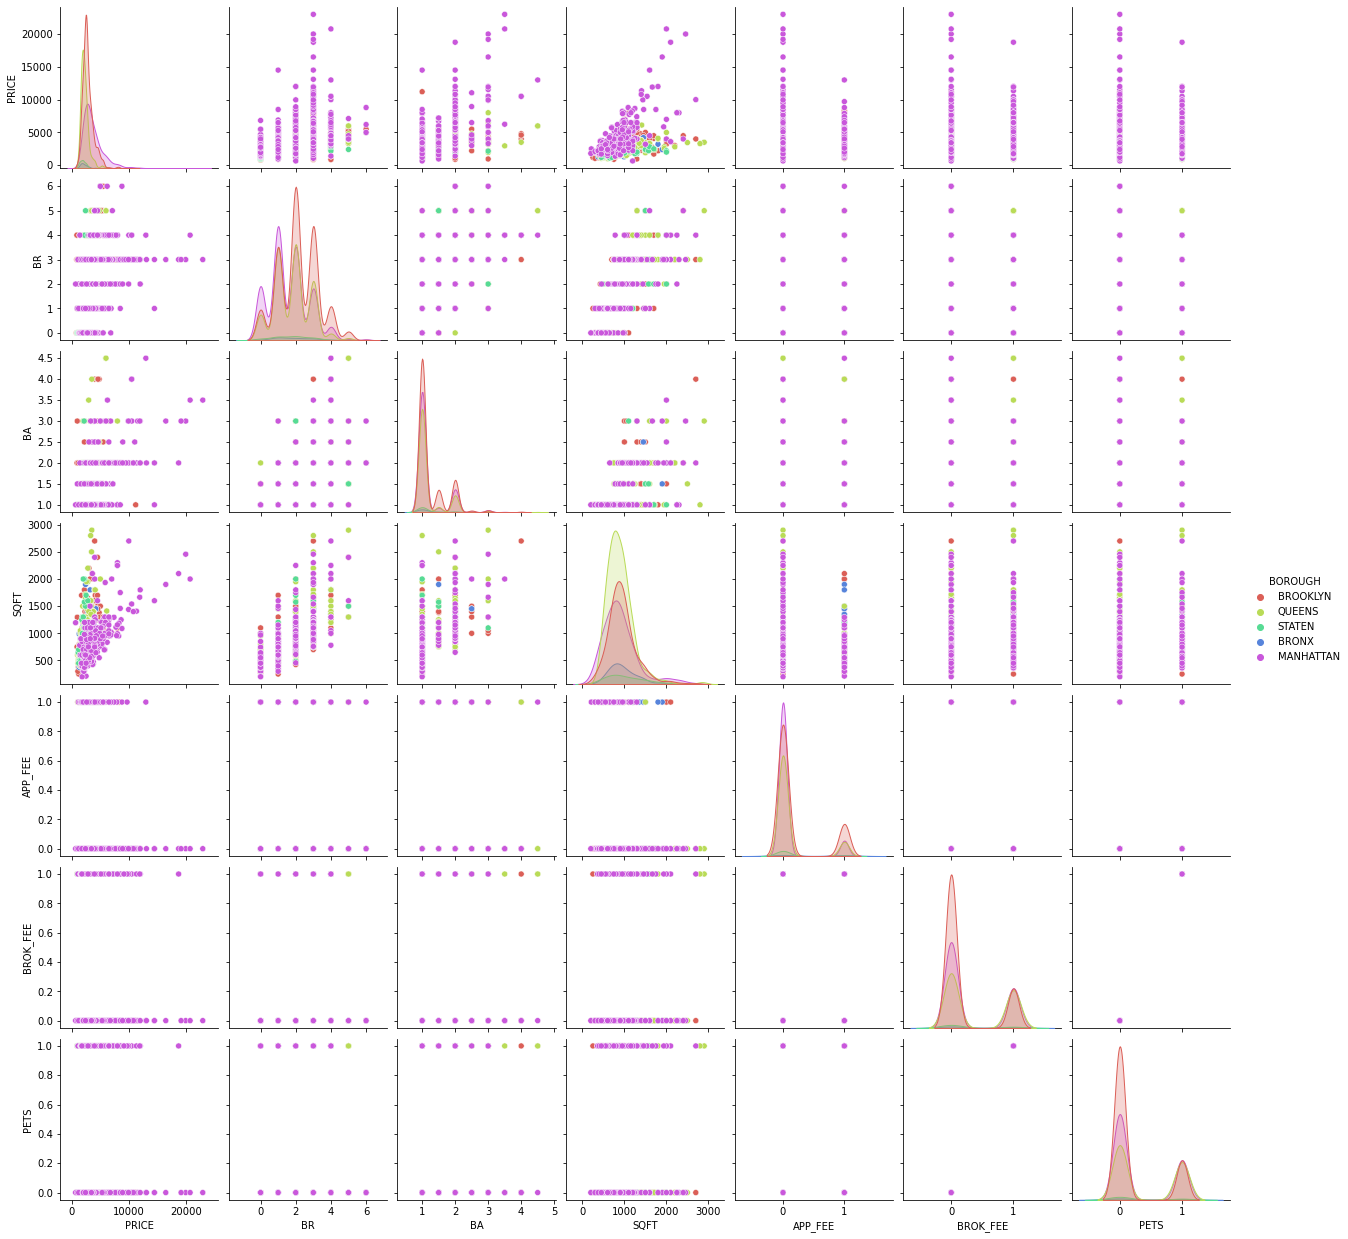

In [9]:
sns.pairplot(nyc, hue='BOROUGH', palette='hls', kind='scatter')

In [10]:
nyc_merged.corr()

,PRICE,BR,BA,SQFT,APP_FEE,BROK_FEE,PETS,WD_none,WD_on site,PARKING_off-street,PARKING_valet,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN
PRICE,1.000000,0.358431,0.493049,0.469367,-0.057764,-0.005242,-0.005242,-0.286191,0.056203,0.122497,0.063470,-0.075958,0.369386,-0.263980,-0.096353
BR,0.358431,1.000000,0.477761,0.678813,-0.018736,-0.090043,-0.090043,-0.011227,-0.057924,-0.016843,0.012933,0.199585,-0.164866,-0.044470,-0.010950
BA,0.493049,0.477761,1.000000,0.571706,-0.008830,-0.004998,-0.004998,-0.149095,-0.019507,0.084583,0.030792,0.046937,-0.004923,-0.040672,-0.014550
SQFT,0.469367,0.678813,0.571706,1.000000,-0.088503,0.007436,0.007436,-0.022393,-0.145601,0.078786,0.065880,0.045142,-0.030449,-0.046495,0.054636
APP_FEE,-0.057764,-0.018736,-0.008830,-0.088503,1.000000,0.194077,0.194077,-0.005365,0.042275,-0.023596,-0.025829,0.116504,-0.105145,-0.036247,-0.020694
BROK_FEE,-0.005242,-0.090043,-0.004998,0.007436,0.194077,1.000000,1.000000,0.153587,-0.096088,-0.120555,-0.016943,-0.161742,0.030839,0.144508,-0.001454
PETS,-0.005242,-0.090043,-0.004998,0.007436,0.194077,1.000000,1.000000,0.153587,-0.096088,-0.120555,-0.016943,-0.161742,0.030839,0.144508,-0.001454
WD_none,-0.286191,-0.011227,-0.149095,-0.022393,-0.005365,0.153587,0.153587,1.000000,-0.714038,-0.180403,-0.050482,-0.055106,-0.170538,0.225088,0.061232
WD_on site,0.056203,-0.057924,-0.019507,-0.145601,0.042275,-0.096088,-0.096088,-0.714038,1.000000,0.078098,0.005262,0.052622,0.077725,-0.132520,-0.055306
PARKING_off-street,0.122497,-0.016843,0.084583,0.078786,-0.023596,-0.120555,-0.120555,-0.180403,0.078098,1.000000,-0.036024,-0.097410,0.056124,0.034262,0.046537


Text(0.5, 1.0, 'Correlation Heatmap')

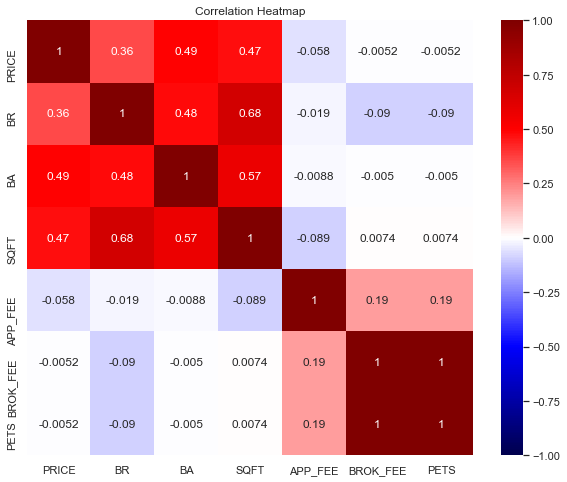

In [11]:
sns.set_theme(style='dark')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(nyc.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap')

Text(0.5, 1.0, 'Correlation Heatmap')

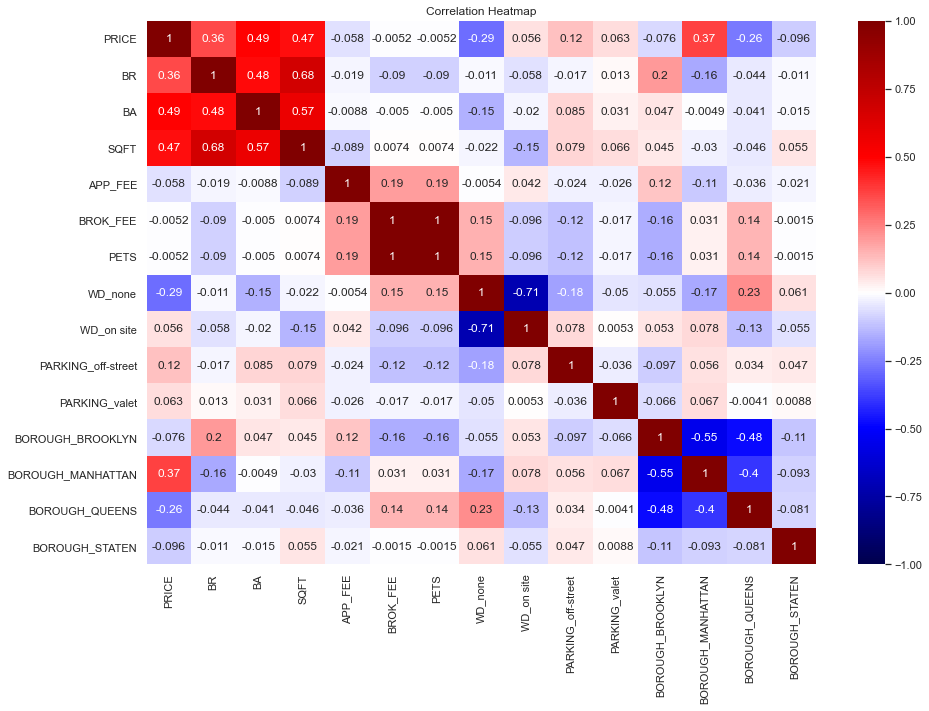

In [12]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(nyc_merged.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap')

Text(0.5, 1.0, 'Price vs. Square Footage of NYC Apts')

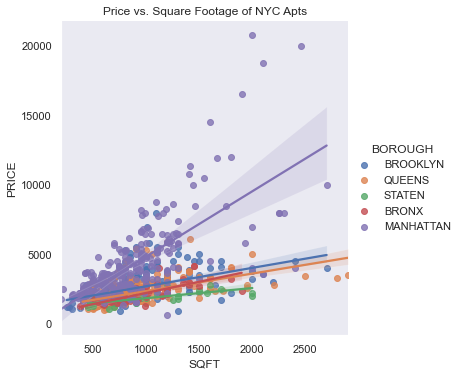

In [13]:
sns.lmplot(x='SQFT', y='PRICE', data=nyc_merged, hue='BOROUGH')
ax = plt.gca()
ax.set_title('Price vs. Square Footage of NYC Apts')

Text(0.5, 1.0, 'Price vs. Bedrooms')

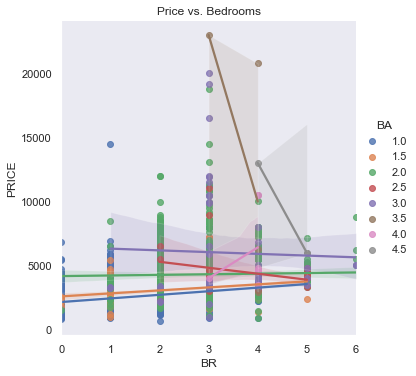

In [14]:
sns.lmplot(x='BR', y='PRICE', data=nyc_merged, hue='BA')
ax = plt.gca()
ax.set_title('Price vs. Bedrooms')

Text(0.5, 1.0, 'Price vs. Bathrooms')

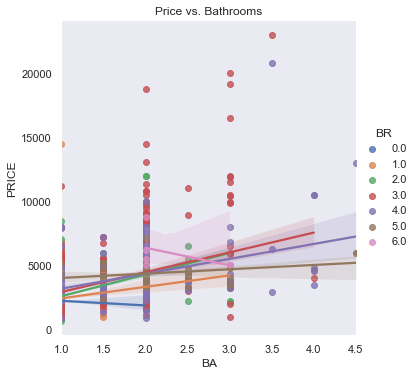

In [15]:
sns.lmplot(x='BA', y='PRICE', data=nyc_merged, hue='BR')
ax = plt.gca()
ax.set_title('Price vs. Bathrooms')

Text(0.5, 1.0, 'Frequency of # of Bedrooms')

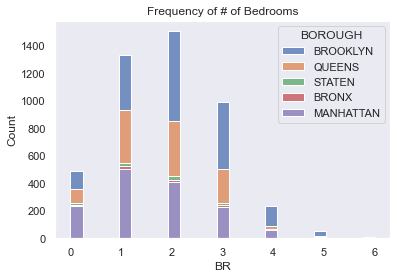

In [16]:
sns.histplot(x='BR', data=nyc_merged, hue='BOROUGH', multiple='stack')
ax = plt.gca()
ax.set_title('Frequency of # of Bedrooms')

Text(0.5, 1.0, 'Frequency of # of Bedrooms')

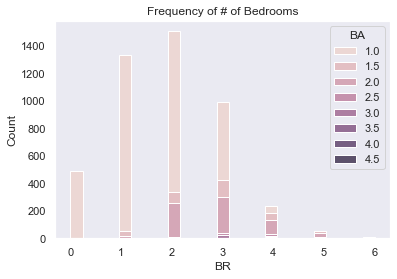

In [17]:
sns.histplot(x='BR', data=nyc_merged, hue='BA', multiple='stack')
ax = plt.gca()
ax.set_title('Frequency of # of Bedrooms')

Text(0.5, 1.0, 'Frequency of Apt by # of Bathrooms')

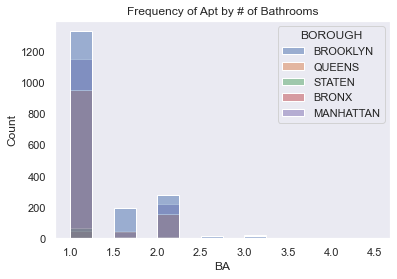

In [18]:
sns.histplot(x='BA', data=nyc_merged, hue='BOROUGH')
ax = plt.gca()
ax.set_title('Frequency of Apt by # of Bathrooms')

<AxesSubplot:xlabel='PARKING', ylabel='Count'>

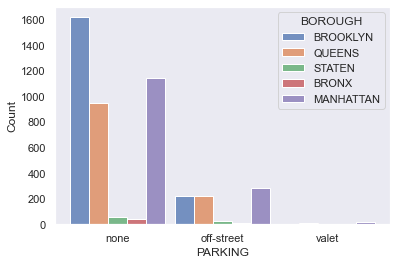

In [19]:
sns.histplot(x='PARKING', data=nyc, hue='BOROUGH', multiple='dodge', shrink=0.9)

<AxesSubplot:xlabel='WD', ylabel='Count'>

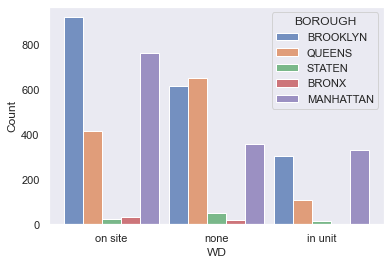

In [20]:
sns.histplot(x='WD', data=nyc, hue='BOROUGH', multiple='dodge', shrink = 0.9)

<AxesSubplot:xlabel='SQFT', ylabel='Count'>

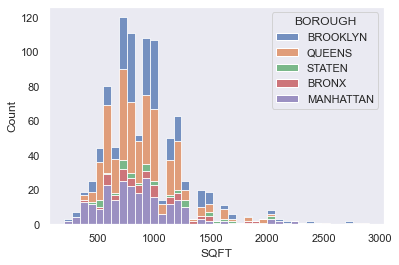

In [21]:
sns.histplot(x='SQFT', data=nyc, hue='BOROUGH', multiple='stack')

<AxesSubplot:xlabel='PRICE', ylabel='Count'>

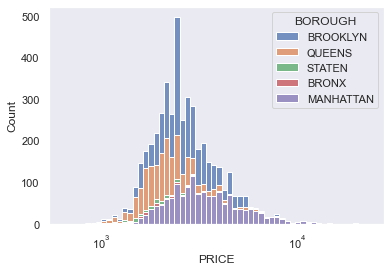

In [22]:
sns.histplot(x='PRICE', data=nyc, hue='BOROUGH', multiple='stack', log_scale=True)

# PREPROCESSING

In [23]:
#split into training and testing sets
from sklearn.model_selection import train_test_split

X = nyc_merged.drop(columns='PRICE')
y = nyc_merged.PRICE

#partition data into train/test data
X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 10)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3687 entries, 4118 to 1289
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BOROUGH             3687 non-null   object 
 1   BR                  3687 non-null   float64
 2   BA                  3687 non-null   float64
 3   SQFT                764 non-null    float64
 4   APP_FEE             3687 non-null   int64  
 5   BROK_FEE            3687 non-null   int64  
 6   PETS                3687 non-null   int64  
 7   WD_none             3687 non-null   uint8  
 8   WD_on site          3687 non-null   uint8  
 9   PARKING_off-street  3687 non-null   uint8  
 10  PARKING_valet       3687 non-null   uint8  
 11  BOROUGH_BROOKLYN    3687 non-null   uint8  
 12  BOROUGH_MANHATTAN   3687 non-null   uint8  
 13  BOROUGH_QUEENS      3687 non-null   uint8  
 14  BOROUGH_STATEN      3687 non-null   uint8  
dtypes: float64(3), int64(3), object(1), uint8(8)
memory 

In [24]:
#fill in missing SQFT values with the median

##first create dictionaries for each borough showing the median sq footage grouped by # of bedrooms
brk = (X.loc[X['BOROUGH'] == 'BROOKLYN']).groupby(['BR']).SQFT.median()
brk_dict = brk.to_dict()

mnh = (X.loc[X['BOROUGH'] == 'MANHATTAN']).groupby(['BR']).SQFT.median()
mnh_dict = mnh.to_dict()

que = (X.loc[X['BOROUGH'] == 'QUEENS']).groupby(['BR']).SQFT.median()
que_dict = que.to_dict()

brx = (X.loc[X['BOROUGH'] == 'BRONX']).groupby(['BR']).SQFT.median()
brx_dict = brx.to_dict()

stn = (X.loc[X['BOROUGH'] == 'STATEN']).groupby(['BR']).SQFT.median()
stn_dict = stn.to_dict()

In [25]:
brk_missing = X.loc[(X['BOROUGH']=='BROOKLYN') & X.SQFT.isna()]
mnh_missing = X.loc[(X['BOROUGH']=='MANHATTAN') & X.SQFT.isna()]
que_missing = X.loc[(X['BOROUGH']=='QUEENS') & X.SQFT.isna()]
brx_missing = X.loc[(X['BOROUGH']=='BRONX') & X.SQFT.isna()]
stn_missing = X.loc[(X['BOROUGH']=='STATEN') & X.SQFT.isna()]

In [26]:
##next transfer values from dictionaries to NA values
def sqft_filler(row, borough_dict):
    for k, v in borough_dict.items():
        if row['BR'] == k:
            return v

In [27]:
##applying the function
brk_missing['SQFT'] = brk_missing.apply(sqft_filler, borough_dict=brk_dict, axis=1)
mnh_missing['SQFT'] = mnh_missing.apply(sqft_filler, borough_dict=mnh_dict, axis=1)
que_missing['SQFT'] = que_missing.apply(sqft_filler, borough_dict=que_dict, axis=1)
brx_missing['SQFT'] = brx_missing.apply(sqft_filler, borough_dict=brx_dict, axis=1)
stn_missing['SQFT'] = stn_missing.apply(sqft_filler, borough_dict=stn_dict, axis=1)

<ipython-input-27-0b8996aaabf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brk_missing['SQFT'] = brk_missing.apply(sqft_filler, borough_dict=brk_dict, axis=1)
<ipython-input-27-0b8996aaabf5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnh_missing['SQFT'] = mnh_missing.apply(sqft_filler, borough_dict=mnh_dict, axis=1)
<ipython-input-27-0b8996aaabf5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [28]:
#putting it all together
all_missing = pd.concat([brk_missing, mnh_missing, que_missing, brx_missing, stn_missing])

In [29]:
#filling in NA values
X = X.fillna(all_missing)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3687 entries, 4118 to 1289
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BOROUGH             3687 non-null   object 
 1   BR                  3687 non-null   float64
 2   BA                  3687 non-null   float64
 3   SQFT                3679 non-null   float64
 4   APP_FEE             3687 non-null   int64  
 5   BROK_FEE            3687 non-null   int64  
 6   PETS                3687 non-null   int64  
 7   WD_none             3687 non-null   uint8  
 8   WD_on site          3687 non-null   uint8  
 9   PARKING_off-street  3687 non-null   uint8  
 10  PARKING_valet       3687 non-null   uint8  
 11  BOROUGH_BROOKLYN    3687 non-null   uint8  
 12  BOROUGH_MANHATTAN   3687 non-null   uint8  
 13  BOROUGH_QUEENS      3687 non-null   uint8  
 14  BOROUGH_STATEN      3687 non-null   uint8  
dtypes: float64(3), int64(3), object(1), uint8(8)
memory 

In [31]:
#dropping remaining rows with NA sqft values from the target set
dropfromy = (X[X['SQFT'].isna()]).index.to_list()
y = y.drop(dropfromy)

In [32]:
#dropping the NA values and the borough column from the feature set
X = X[~X['SQFT'].isna()]
X = X.drop(columns=['BOROUGH'])

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3679 entries, 4118 to 1289
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BR                  3679 non-null   float64
 1   BA                  3679 non-null   float64
 2   SQFT                3679 non-null   float64
 3   APP_FEE             3679 non-null   int64  
 4   BROK_FEE            3679 non-null   int64  
 5   PETS                3679 non-null   int64  
 6   WD_none             3679 non-null   uint8  
 7   WD_on site          3679 non-null   uint8  
 8   PARKING_off-street  3679 non-null   uint8  
 9   PARKING_valet       3679 non-null   uint8  
 10  BOROUGH_BROOKLYN    3679 non-null   uint8  
 11  BOROUGH_MANHATTAN   3679 non-null   uint8  
 12  BOROUGH_QUEENS      3679 non-null   uint8  
 13  BOROUGH_STATEN      3679 non-null   uint8  
dtypes: float64(3), int64(3), uint8(8)
memory usage: 229.9 KB


# ----------------- FEATURE ENGINEERING FOR TEST DATA   ----------------- 

In [34]:
#doing the feature engineering again for the test data
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 1327 to 2242
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BOROUGH             922 non-null    object 
 1   BR                  922 non-null    float64
 2   BA                  922 non-null    float64
 3   SQFT                205 non-null    float64
 4   APP_FEE             922 non-null    int64  
 5   BROK_FEE            922 non-null    int64  
 6   PETS                922 non-null    int64  
 7   WD_none             922 non-null    uint8  
 8   WD_on site          922 non-null    uint8  
 9   PARKING_off-street  922 non-null    uint8  
 10  PARKING_valet       922 non-null    uint8  
 11  BOROUGH_BROOKLYN    922 non-null    uint8  
 12  BOROUGH_MANHATTAN   922 non-null    uint8  
 13  BOROUGH_QUEENS      922 non-null    uint8  
 14  BOROUGH_STATEN      922 non-null    uint8  
dtypes: float64(3), int64(3), object(1), uint8(8)
memory u

In [35]:
#creating dictionaries of median sqft values
tbrk = (X_test.loc[X_test['BOROUGH'] == 'BROOKLYN']).groupby(['BR']).SQFT.median()
tbrk_dict = tbrk.to_dict()

tmnh = (X_test.loc[X_test['BOROUGH'] == 'MANHATTAN']).groupby(['BR']).SQFT.median()
tmnh_dict = tmnh.to_dict()

tque = (X_test.loc[X_test['BOROUGH'] == 'QUEENS']).groupby(['BR']).SQFT.median()
tque_dict = tque.to_dict()

tbrx = (X_test.loc[X_test['BOROUGH'] == 'BRONX']).groupby(['BR']).SQFT.median()
tbrx_dict = tbrx.to_dict()

tstn = (X_test.loc[X_test['BOROUGH'] == 'STATEN']).groupby(['BR']).SQFT.median()
tstn_dict = tstn.to_dict()

#creating dataframes of missing sqft values
tbrk_missing = X_test.loc[(X_test['BOROUGH']=='BROOKLYN') & X_test.SQFT.isna()]
tmnh_missing = X_test.loc[(X_test['BOROUGH']=='MANHATTAN') & X_test.SQFT.isna()]
tque_missing = X_test.loc[(X_test['BOROUGH']=='QUEENS') & X_test.SQFT.isna()]
tbrx_missing = X_test.loc[(X_test['BOROUGH']=='BRONX') & X_test.SQFT.isna()]
tstn_missing = X_test.loc[(X_test['BOROUGH']=='STATEN') & X_test.SQFT.isna()]

#filling in missing sqft values based on median
tbrk_missing['SQFT'] = tbrk_missing.apply(sqft_filler, borough_dict=tbrk_dict, axis=1)
tmnh_missing['SQFT'] = tmnh_missing.apply(sqft_filler, borough_dict=tmnh_dict, axis=1)
tque_missing['SQFT'] = tque_missing.apply(sqft_filler, borough_dict=tque_dict, axis=1)
tbrx_missing['SQFT'] = tbrx_missing.apply(sqft_filler, borough_dict=tbrx_dict, axis=1)
tstn_missing['SQFT'] = tstn_missing.apply(sqft_filler, borough_dict=tstn_dict, axis=1)

#filling in missing sqft values
tall_missing = pd.concat([tbrk_missing, tmnh_missing, tque_missing, tbrx_missing, tstn_missing])
X_test = X_test.fillna(tall_missing)

<ipython-input-35-12c58cd67c12>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbrk_missing['SQFT'] = tbrk_missing.apply(sqft_filler, borough_dict=tbrk_dict, axis=1)
<ipython-input-35-12c58cd67c12>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmnh_missing['SQFT'] = tmnh_missing.apply(sqft_filler, borough_dict=tmnh_dict, axis=1)
<ipython-input-35-12c58cd67c12>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 1327 to 2242
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BOROUGH             922 non-null    object 
 1   BR                  922 non-null    float64
 2   BA                  922 non-null    float64
 3   SQFT                911 non-null    float64
 4   APP_FEE             922 non-null    int64  
 5   BROK_FEE            922 non-null    int64  
 6   PETS                922 non-null    int64  
 7   WD_none             922 non-null    uint8  
 8   WD_on site          922 non-null    uint8  
 9   PARKING_off-street  922 non-null    uint8  
 10  PARKING_valet       922 non-null    uint8  
 11  BOROUGH_BROOKLYN    922 non-null    uint8  
 12  BOROUGH_MANHATTAN   922 non-null    uint8  
 13  BOROUGH_QUEENS      922 non-null    uint8  
 14  BOROUGH_STATEN      922 non-null    uint8  
dtypes: float64(3), int64(3), object(1), uint8(8)
memory u

In [37]:
#dropping missing values from y test set
tdropfromy = (X_test[X_test['SQFT'].isna()]).index.to_list()
y_test = y_test.drop(tdropfromy)

In [38]:
#dropping borough and NA values
X_test = X_test[~X_test['SQFT'].isna()]
X_test = X_test.drop(columns=['BOROUGH'])

In [39]:
#BR-BA interaction term and #MNH-SQFT interaction term

In [40]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 1327 to 998
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BR                  911 non-null    float64
 1   BA                  911 non-null    float64
 2   SQFT                911 non-null    float64
 3   APP_FEE             911 non-null    int64  
 4   BROK_FEE            911 non-null    int64  
 5   PETS                911 non-null    int64  
 6   WD_none             911 non-null    uint8  
 7   WD_on site          911 non-null    uint8  
 8   PARKING_off-street  911 non-null    uint8  
 9   PARKING_valet       911 non-null    uint8  
 10  BOROUGH_BROOKLYN    911 non-null    uint8  
 11  BOROUGH_MANHATTAN   911 non-null    uint8  
 12  BOROUGH_QUEENS      911 non-null    uint8  
 13  BOROUGH_STATEN      911 non-null    uint8  
dtypes: float64(3), int64(3), uint8(8)
memory usage: 56.9 KB


# -------------- END FEATURE ENGINEERING FOR TEST DATA ------------------

In [41]:
#trying out OLS Regression
#adding a constant to X
Xc = sm.add_constant(X)

OLSmodel = sm.OLS(y, Xc)

#Fit the model
OLSfit = OLSmodel.fit()

#print statistics of the fitted model
print(OLSfit.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     264.9
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:12:25   Log-Likelihood:                -30875.
No. Observations:                3679   AIC:                         6.178e+04
Df Residuals:                    3665   BIC:                         6.187e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 82.5776    192

In [42]:
#look for influential points
influence = OLSfit.get_influence()
influence_frame = influence.summary_frame().reset_index()

influence_frame[influence_frame['cooks_d'] > 0.5]

,index,dfb_const,dfb_BR,dfb_BA,dfb_SQFT,dfb_APP_FEE,dfb_BROK_FEE,dfb_PETS,dfb_WD_none,dfb_WD_on site,...,dfb_BOROUGH_BROOKLYN,dfb_BOROUGH_MANHATTAN,dfb_BOROUGH_QUEENS,dfb_BOROUGH_STATEN,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
514,3975,-0.902432,-1.643338,0.469584,1.860712,0.072015,-0.235928,-0.235928,0.033721,-0.126908,...,0.136498,0.158319,0.172244,-0.061332,0.666873,11.310854,0.072518,3.162766,11.512023,3.219017


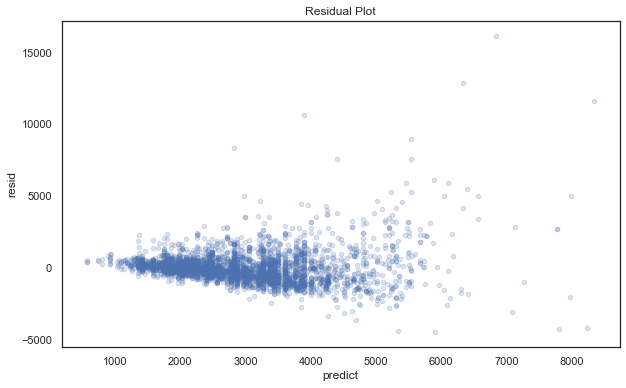

In [43]:
#plotting residuals
X['predict'] = OLSfit.predict(Xc)
X['resid'] = y - X['predict']
with sns.axes_style('white'):
    plot=X.plot(kind='scatter',
                  x='predict',y='resid', alpha=0.2, color='b', figsize=(10,6), title='Residual Plot')

The result is very not normal! What to do?????

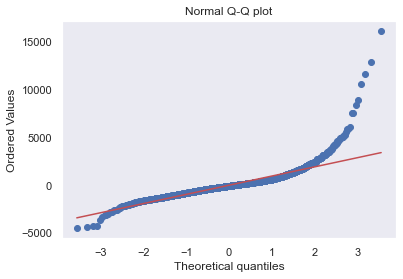

In [44]:
stats.probplot(X['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [45]:
X = X.drop(columns=['predict','resid'])

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#ignore intercept VIF
#drop a variable or combine features, run again and and see how VIF is affected

vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

/Users/ami/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,vif
0,BR,14.898462
1,BA,11.576037
2,SQFT,45.090260
3,APP_FEE,1.244559
4,BROK_FEE,inf
5,PETS,inf
6,WD_none,3.443927
7,WD_on site,3.692024
8,PARKING_off-street,1.293388
9,PARKING_valet,1.020680


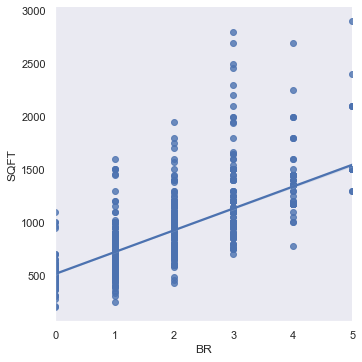

In [47]:
#might have to deal with multicollinearity
sns.lmplot(x="BR", y="SQFT", data=X)

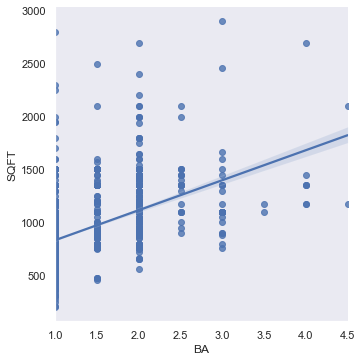

In [48]:
sns.lmplot(x="BA", y="SQFT", data=X)

# X: Getting an initial read on things

In [49]:
#normalize the data
from sklearn.preprocessing import StandardScaler
## .fit finds the mean and standard deviation of each variable in the training set
std = StandardScaler()
std.fit(X)

##apply the scaler to the train set
X_tr_scaled = std.transform(X)

In [50]:
#CROSS VALIDATION TIME!!!!!
y = np.array(y)

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score

In [51]:
linreg = LinearRegression()

linreg_score_r2 = cross_val_score(linreg, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [52]:
np.mean(linreg_score_r2)

0.47187010818959507

In [53]:
np.mean(linreg_score_MAE)

-675.037628274906

In [54]:
np.mean(linreg_score_RMSE)

-1073.3423203121667

In [55]:
#trying ridge regression
alphas = 10**np.linspace(-2, 2, 200)

ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X_tr_scaled, y)

ridge_model.alpha_

4.7137531341167245

In [56]:
ridge_model = Ridge(alpha = 4.7)

ridge_score_r2 = cross_val_score(ridge_model, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

ridge_score_MAE = cross_val_score(ridge_model, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error') # scoring metric

ridge_score_RMSE = cross_val_score(ridge_model, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error') # scoring metric

In [57]:
np.mean(ridge_score_r2)

0.47233498592884005

In [58]:
np.mean(ridge_score_MAE)

-674.5948972497205

In [59]:
np.mean(ridge_score_RMSE)

-1072.8918070530494

In [60]:
#lasso regression

#finding the best alpha
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_scaled, y)

lasso_model.alpha_

0.09658832241158703

In [61]:
lasso_model = Lasso(alpha = 0.1)

lasso_score_r2 = cross_val_score(lasso_model, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

lasso_score_MAE = cross_val_score(lasso_model, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error') # scoring metric

lasso_score_RMSE = cross_val_score(lasso_model, X_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error') # scoring metric

In [62]:
np.mean(lasso_score_r2)

0.4723237728318292

In [63]:
np.mean(lasso_score_MAE)

-674.7520667330523

In [64]:
np.mean(lasso_score_RMSE)

-1072.8843048270915

In [65]:
#trying polynomial regression
from sklearn.preprocessing import PolynomialFeatures

In [66]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_tr_scaled)


# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y)
lr_poly.score(X_train_poly,y)

0.6136804840279086

# X2: Dropping application fee

In [67]:
#dropping some features might help
X2 = X.drop(columns=['APP_FEE'])

In [68]:
#scaling again
std.fit(X2)
X2_tr_scaled = std.transform(X2)

In [69]:
linreg_score_r2 = cross_val_score(linreg, X2_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X2_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X2_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [70]:
np.mean(linreg_score_r2)

0.47249557699604755

In [71]:
np.mean(linreg_score_MAE)

-674.0234096355865

In [72]:
np.mean(linreg_score_RMSE)

-1072.6432760516273

In [73]:
#trying polynomial regression again too
poly = PolynomialFeatures(degree=2)
X2_train_poly = poly.fit_transform(X2_tr_scaled)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X2_train_poly,y)
lr_poly.score(X2_train_poly,y)

0.6110270595095721

In [74]:
#cross val score for polynomial regression?
polyreg_score_r2 = cross_val_score(lr_poly, X2_train_poly, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

In [75]:
polyreg_score_r2
#why does it look like this?????

array([-3.97019224e+22, -1.40457498e+21,  4.67057121e-01])

In [76]:
#trying ridge again
alphas = 10**np.linspace(-2, 2, 200)

ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X2_tr_scaled, y)

ridge_model.alpha_

4.937047852839004

In [77]:
ridge_model = Ridge(alpha = 4.9)

ridge_score_r2 = cross_val_score(ridge_model, X2_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

ridge_score_MAE = cross_val_score(ridge_model, X2_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error') # scoring metric

ridge_score_RMSE = cross_val_score(ridge_model, X2_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error') # scoring metric

In [78]:
np.mean(ridge_score_r2)

0.4725736531376922

In [79]:
np.mean(ridge_score_MAE)

-673.689246358522

In [80]:
np.mean(ridge_score_RMSE)

-1072.5964303250605

In [81]:
#trying out OLS Regression
#adding a constant to X
X2c = sm.add_constant(X2)

OLSmodel = sm.OLS(y, X2c)

#Fit the model
OLSfit = OLSmodel.fit()

#print statistics of the fitted model
print(OLSfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     286.8
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:12:35   Log-Likelihood:                -30876.
No. Observations:                3679   AIC:                         6.178e+04
Df Residuals:                    3666   BIC:                         6.186e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 54.2593    191

In [82]:
#what about the VIF score?
vif = pd.DataFrame()
vif['variables'] = X2.columns
vif['vif'] =[variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif

/Users/ami/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,vif
0,BR,14.884014
1,BA,11.570007
2,SQFT,45.076038
3,BROK_FEE,inf
4,PETS,inf
5,WD_none,3.439334
6,WD_on site,3.669287
7,PARKING_off-street,1.292384
8,PARKING_valet,1.020670
9,BOROUGH_BROOKLYN,9.787759


# X3: DROPPING APP FEE AND PETS

In [83]:
#no big difference--what if we dropped pets too?
X3 = X.drop(columns=['APP_FEE','PETS'])

In [84]:
#scaling again
std.fit(X3)
X3_tr_scaled = std.transform(X3)

In [85]:
linreg_score_r2 = cross_val_score(linreg, X3_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X3_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X3_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [86]:
np.mean(linreg_score_r2)

0.472555936368674

In [87]:
np.mean(linreg_score_MAE)

-673.9142342856825

In [88]:
np.mean(linreg_score_RMSE)

-1072.593806421592

In [89]:
#trying polynomial regression again too
poly = PolynomialFeatures(degree=2)
X3_train_poly = poly.fit_transform(X3_tr_scaled)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X3_train_poly,y)
lr_poly.score(X3_train_poly,y)

0.6106700529887245

In [90]:
#not better, should probably keep pets

# X4: COMBINING FEATURES

In [91]:
#again no big differences
#now will try to represent BA & BR as a single term and drop BA & BR to reduce multicollinearity

#first going to change 0BR apts (studios) to 0.5
X.loc[X['BR'] == 0, 'BR'] = 0.5

#creating new interaction term???? i guess
X['BA-BR'] = X['BA'] * X['BR']
X.head()

,BR,BA,SQFT,APP_FEE,BROK_FEE,PETS,WD_none,WD_on site,PARKING_off-street,PARKING_valet,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN,BA-BR
4118,1.0,1.0,761.0,0,0,0,0,1,0,0,0,1,0,0,1.0
2087,2.0,1.0,880.0,0,0,0,0,1,0,0,0,0,1,0,2.0
4220,0.5,1.0,453.0,0,1,1,0,1,0,0,0,1,0,0,0.5
2886,2.0,1.0,880.0,1,1,1,1,0,1,0,0,0,1,0,2.0
476,2.0,1.0,850.0,0,1,1,0,0,0,0,1,0,0,0,2.0


In [92]:
X4 = X.drop(columns=['BA','BR','APP_FEE'])

In [93]:
#scaling again
std = StandardScaler()
std.fit(X4)

##apply the scaler to the train set
X4_tr_scaled = std.transform(X4)

In [94]:
linreg_score_r2 = cross_val_score(linreg, X4_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X4_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X4_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [95]:
np.mean(linreg_score_r2)

0.453362949990985

In [96]:
np.mean(linreg_score_MAE)

-676.3727610224709

In [97]:
np.mean(linreg_score_RMSE)

-1093.201204074581

In [98]:
#trying polynomial regression 
poly = PolynomialFeatures(degree=2)
X4_train_poly = poly.fit_transform(X4_tr_scaled)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X4_train_poly,y)
lr_poly.score(X4_train_poly,y)

0.5638438543283282

In [99]:
#results are even worse but how about VIF?
vif = pd.DataFrame()
vif['variables'] = X4.columns
vif['vif'] =[variance_inflation_factor(X4_tr_scaled, i) for i in range(X4.shape[1])]
vif

/Users/ami/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,vif
0,SQFT,2.344888
1,BROK_FEE,inf
2,PETS,inf
3,WD_none,2.325300
4,WD_on site,2.131449
5,PARKING_off-street,1.075739
6,PARKING_valet,1.015082
7,BOROUGH_BROOKLYN,19.870217
8,BOROUGH_MANHATTAN,18.041562
9,BOROUGH_QUEENS,16.112493


# X5 Dropping SQFT

In [100]:
#not too bad when data is scaled-- what if we dropped sqft
X5 = X.drop(columns=['BR','BA','APP_FEE','SQFT'])

In [101]:
#scaling again
std = StandardScaler()
std.fit(X5)

##apply the scaler to the train set
X5_tr_scaled = std.transform(X5)

In [102]:
linreg_score_r2 = cross_val_score(linreg, X5_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X5_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X5_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [103]:
np.mean(linreg_score_r2)

0.4405931006953514

In [104]:
np.mean(linreg_score_MAE)

-682.2517275371478

In [105]:
np.mean(linreg_score_RMSE)

-1105.1388759263336

In [106]:
#trying polynomial regression even though it's probably going to be worse too
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X5_tr_scaled)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y)
lr_poly.score(X_train_poly, y)

0.5406441173690226

In [107]:
#model is doing worse, but how's the VIF now
vif = pd.DataFrame()
vif['variables'] = X5.columns
vif['vif'] =[variance_inflation_factor(X5_tr_scaled, i) for i in range(X5.shape[1])]
vif

/Users/ami/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,vif
0,BROK_FEE,inf
1,PETS,inf
2,WD_none,2.326258
3,WD_on site,2.132734
4,PARKING_off-street,1.076363
5,PARKING_valet,1.014416
6,BOROUGH_BROOKLYN,19.919696
7,BOROUGH_MANHATTAN,17.972505
8,BOROUGH_QUEENS,16.067082
9,BOROUGH_STATEN,2.451531


In [108]:
#VIF is better now, but at what cost?

# X6: Dropping BA/BR and keeping SQFT

In [109]:
X6 = X.drop(columns=['BA','BR','BA-BR','APP_FEE'])

In [110]:
#scaling again
std = StandardScaler()
std.fit(X6)

##apply the scaler to the train set
X6_tr_scaled = std.transform(X6)

In [111]:
linreg_score_r2 = cross_val_score(linreg, X6_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X6_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X6_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [112]:
np.mean(linreg_score_r2)

0.40788881418269335

In [113]:
np.mean(linreg_score_MAE)

-699.5070627873414

In [114]:
np.mean(linreg_score_RMSE)

-1139.5216288943302

In [115]:
#trying polynomial regression 
poly = PolynomialFeatures(degree=2)
X6_train_poly = poly.fit_transform(X6_tr_scaled)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X6_train_poly,y)
lr_poly.score(X6_train_poly,y)

0.4821437935381775

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#ignore intercept VIF
#drop a variable or combine features, run again and and see how VIF is affected

vif = pd.DataFrame()
vif['variables'] = X6.columns
vif['vif'] =[variance_inflation_factor(X6_tr_scaled, i) for i in range(X6.shape[1])]
vif

/Users/ami/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,vif
0,SQFT,1.065543
1,BROK_FEE,inf
2,PETS,inf
3,WD_none,2.288280
4,WD_on site,2.113048
5,PARKING_off-street,1.075817
6,PARKING_valet,1.015060
7,BOROUGH_BROOKLYN,19.843566
8,BOROUGH_MANHATTAN,18.007197
9,BOROUGH_QUEENS,16.076249


In [117]:
#why is VIF so high for the dummy variables???

# X7: Including BA/BR (plus BA and BR), only excluding APP FEE

In [118]:
X7 = X.drop(columns=['APP_FEE'])

In [119]:
#scaling again
std = StandardScaler()
std.fit(X7)

##apply the scaler to the train set
X7_tr_scaled = std.transform(X7)

In [120]:
vif = pd.DataFrame()
vif['variables'] = X7.columns
vif['vif'] =[variance_inflation_factor(X7_tr_scaled, i) for i in range(X7.shape[1])]
vif

/Users/ami/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,vif
0,BR,12.360602
1,BA,9.987558
2,SQFT,3.830448
3,BROK_FEE,inf
4,PETS,inf
5,WD_none,2.388890
6,WD_on site,2.166306
7,PARKING_off-street,1.082503
8,PARKING_valet,1.015156
9,BOROUGH_BROOKLYN,19.982633


In [121]:
linreg_score_r2 = cross_val_score(linreg, X7_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X7_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X7_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [122]:
np.mean(linreg_score_r2)

0.4735243061710513

In [123]:
np.mean(linreg_score_MAE)

-673.4097416687637

In [124]:
np.mean(linreg_score_RMSE)

-1071.3501723068698

In [125]:
#trying polynomial regression, this time with higher degree
poly = PolynomialFeatures(degree=4)
X7_train_poly = poly.fit_transform(X7_tr_scaled)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X7_train_poly,y)
lr_poly.score(X7_train_poly,y)

#why is this better????

0.756084652008711

# X8: Adding interaction term for Manhattan x SQFT? Trying a different interaction term for BR and BA? (dropping appfee, pets)

In [174]:
X['MNH-SQFT'] = X['SQFT'] * X['BOROUGH_MANHATTAN']

In [175]:
#trying a different interaction term for bedrooms and bathrooms
X['BR-BA'] = X['BR'] / X['BA']

In [176]:
X8 = X.drop(columns=['APP_FEE','PETS', 'BA-BR'])

In [177]:
X8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3679 entries, 4118 to 1289
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BR                  3679 non-null   float64
 1   BA                  3679 non-null   float64
 2   SQFT                3679 non-null   float64
 3   BROK_FEE            3679 non-null   int64  
 4   WD_none             3679 non-null   uint8  
 5   WD_on site          3679 non-null   uint8  
 6   PARKING_off-street  3679 non-null   uint8  
 7   PARKING_valet       3679 non-null   uint8  
 8   BOROUGH_BROOKLYN    3679 non-null   uint8  
 9   BOROUGH_MANHATTAN   3679 non-null   uint8  
 10  BOROUGH_QUEENS      3679 non-null   uint8  
 11  BOROUGH_STATEN      3679 non-null   uint8  
 12  MNH-SQFT            3679 non-null   float64
 13  BR-BA               3679 non-null   float64
dtypes: float64(5), int64(1), uint8(8)
memory usage: 359.0 KB


In [178]:
#scaling again
std = StandardScaler()
std.fit(X8)

##apply the scaler to the train set
X8_tr_scaled = std.transform(X8)

In [179]:
linreg_score_r2 = cross_val_score(linreg, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

linreg_score_MAE = cross_val_score(linreg, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error')

linreg_score_RMSE = cross_val_score(linreg, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error')

In [180]:
np.mean(linreg_score_r2)

0.5145237673776887

In [181]:
np.mean(linreg_score_MAE)

-649.7782541792033

In [182]:
np.mean(linreg_score_RMSE)

-1028.0268465261533

In [183]:
#ridge regression--finding the alpha
alphas = 10**np.linspace(-2, 2, 200)

ridge_model = RidgeCV(alphas = alphas, cv=5)
ridge_model.fit(X8_tr_scaled, y)

ridge_model.alpha_

19.791668678535572

In [184]:
ridge_model = Ridge(alpha = 19.791668678535572)

ridge_score_r2 = cross_val_score(ridge_model, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

ridge_score_MAE = cross_val_score(ridge_model, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error') # scoring metric

ridge_score_RMSE = cross_val_score(ridge_model, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error') # scoring metric

In [185]:
print(np.mean(ridge_score_r2), np.mean(linreg_score_MAE), np.mean(linreg_score_RMSE))

0.5150732959343559 -649.7782541792033 -1028.0268465261533


In [186]:
#finding alpha for lasso
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X8_tr_scaled, y)

lasso_model.alpha_

0.29331662783900436

In [187]:
lasso_model = Lasso(alpha = 0.29331662783900436)

lasso_score_r2 = cross_val_score(lasso_model, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

lasso_score_MAE = cross_val_score(lasso_model, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error') # scoring metric

lasso_score_RMSE = cross_val_score(lasso_model, X8_tr_scaled, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_root_mean_squared_error') # scoring metric

In [188]:
print(np.mean(lasso_score_r2), np.mean(lasso_score_MAE), np.mean(lasso_score_RMSE))

0.5145992061573719 -649.5818802577718 -1027.995666769461


In [189]:
#Curious about OLS
#adding a constant to X
X8c = sm.add_constant(X8)

OLSmodel = sm.OLS(y, X8c)

#Fit the model
OLSfit = OLSmodel.fit()

#print statistics of the fitted model
print(OLSfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     291.6
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:17:34   Log-Likelihood:                -30717.
No. Observations:                3679   AIC:                         6.146e+04
Df Residuals:                    3664   BIC:                         6.156e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                163.5424    221

In [190]:
vif = pd.DataFrame()
vif['variables'] = X8.columns
vif['vif'] =[variance_inflation_factor(X8_tr_scaled, i) for i in range(X8.shape[1])]
vif

,variables,vif
0,BR,24.644380
1,BA,8.578669
2,SQFT,4.500573
3,BROK_FEE,1.081109
4,WD_none,2.403801
5,WD_on site,2.187860
6,PARKING_off-street,1.084469
7,PARKING_valet,1.018723
8,BOROUGH_BROOKLYN,19.977865
9,BOROUGH_MANHATTAN,30.032833


# But is there overfitting? Applying the model to the test data

In [191]:
#applying same feature engineering to test data
X_test['MNH-SQFT'] = X_test['SQFT'] * X_test['BOROUGH_MANHATTAN']
X_test.loc[X_test['BR'] == 0, 'BR'] = 0.5
X_test['BR-BA'] = X_test['BR'] / X_test['BA']
X_test1 = X_test.drop(columns=['APP_FEE','PETS'])
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 1327 to 998
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BR                  911 non-null    float64
 1   BA                  911 non-null    float64
 2   SQFT                911 non-null    float64
 3   BROK_FEE            911 non-null    int64  
 4   WD_none             911 non-null    uint8  
 5   WD_on site          911 non-null    uint8  
 6   PARKING_off-street  911 non-null    uint8  
 7   PARKING_valet       911 non-null    uint8  
 8   BOROUGH_BROOKLYN    911 non-null    uint8  
 9   BOROUGH_MANHATTAN   911 non-null    uint8  
 10  BOROUGH_QUEENS      911 non-null    uint8  
 11  BOROUGH_STATEN      911 non-null    uint8  
 12  MNH-SQFT            911 non-null    float64
 13  BR-BA               911 non-null    float64
dtypes: float64(5), int64(1), uint8(8)
memory usage: 56.9 KB


In [192]:
X8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3679 entries, 4118 to 1289
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BR                  3679 non-null   float64
 1   BA                  3679 non-null   float64
 2   SQFT                3679 non-null   float64
 3   BROK_FEE            3679 non-null   int64  
 4   WD_none             3679 non-null   uint8  
 5   WD_on site          3679 non-null   uint8  
 6   PARKING_off-street  3679 non-null   uint8  
 7   PARKING_valet       3679 non-null   uint8  
 8   BOROUGH_BROOKLYN    3679 non-null   uint8  
 9   BOROUGH_MANHATTAN   3679 non-null   uint8  
 10  BOROUGH_QUEENS      3679 non-null   uint8  
 11  BOROUGH_STATEN      3679 non-null   uint8  
 12  MNH-SQFT            3679 non-null   float64
 13  BR-BA               3679 non-null   float64
dtypes: float64(5), int64(1), uint8(8)
memory usage: 359.0 KB


In [193]:
#scaling again
std = StandardScaler()
std.fit(X_test1)

##apply the scaler to the train set
X_te_scaled = std.transform(X_test1)

In [194]:
#testing out lasso model (X8)
from sklearn.metrics import mean_squared_error, mean_absolute_error

best_model = Lasso(alpha = 0.29331662783900436)
best_model.fit(X8_tr_scaled, y)

train_score = best_model.score(X8_tr_scaled, y)
test_score = best_model.score(X_te_scaled, y_test)

predictions = best_model.predict(X_te_scaled)

test_MAE = mean_absolute_error(predictions, y_test)

test_RMSE = np.sqrt(mean_squared_error(predictions, y_test))

In [195]:
print(train_score, test_score, test_MAE, test_RMSE)

0.527041973448301 0.5187309026024589 676.6757293370574 1128.4995909046065


In [149]:
#testing out polynomial regression
poly = PolynomialFeatures(degree=4)
X8_train_poly = poly.fit_transform(X8_tr_scaled)
#need to transform the test data I guess
X_test_poly = poly.fit_transform(X_te_scaled)

lr_poly = LinearRegression()
lr_poly.fit(X8_train_poly, y)
poly_train_score = lr_poly.score(X8_train_poly,y)
poly_test_score = lr_poly.score(X_test_poly, y_test)
#bad!!!! very bad!!!!

In [150]:
print(poly_train_score, poly_test_score)

0.763050750783988 -7.69323059699641e+21


# Visualizations

<AxesSubplot:xlabel='PARKING', ylabel='Count'>

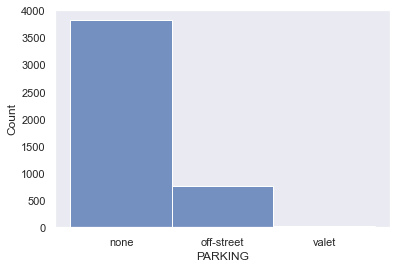

In [151]:
sns.histplot(x='PARKING', data=nyc)

Text(0.5, 1.0, 'Price vs. BA*BR interaction term')

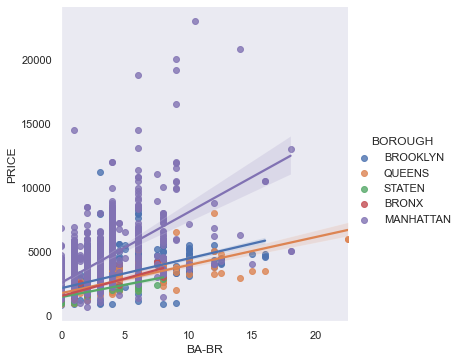

In [152]:
nyc_merged['BA-BR'] = nyc_merged['BA'] * nyc_merged['BR']
sns.lmplot(x='BA-BR', y='PRICE', data=nyc_merged, hue='BOROUGH')
ax.set_title('Price vs. BA*BR interaction term')

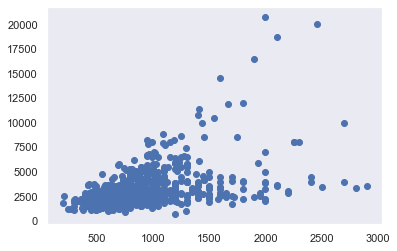

In [153]:
ax = plt.gca()
ax.scatter(nyc_merged['SQFT'], nyc_merged['PRICE'])

<AxesSubplot:title={'center':'# of Listings per Borough'}, xlabel='BOROUGH', ylabel='count'>

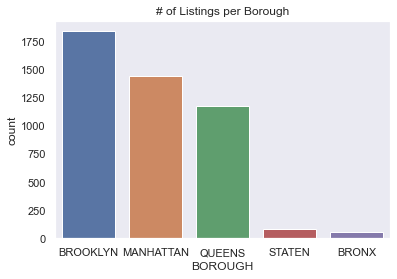

In [154]:
ax = plt.gca()
ax.set_title('# of Listings per Borough')
sns.countplot(x='BOROUGH', data=nyc, order=['BROOKLYN','MANHATTAN','QUEENS','STATEN','BRONX'])

<AxesSubplot:title={'center':'Types of Parking by Borough'}, xlabel='PARKING', ylabel='count'>

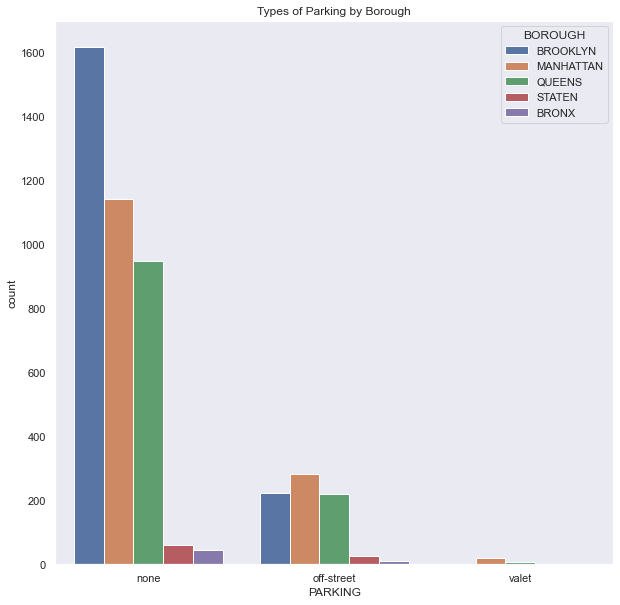

In [155]:
ax = plt.figure(figsize = (10,10))
plt.title('Types of Parking by Borough')
sns.countplot(x='PARKING', data=nyc, hue='BOROUGH', hue_order=['BROOKLYN','MANHATTAN','QUEENS','STATEN','BRONX'])

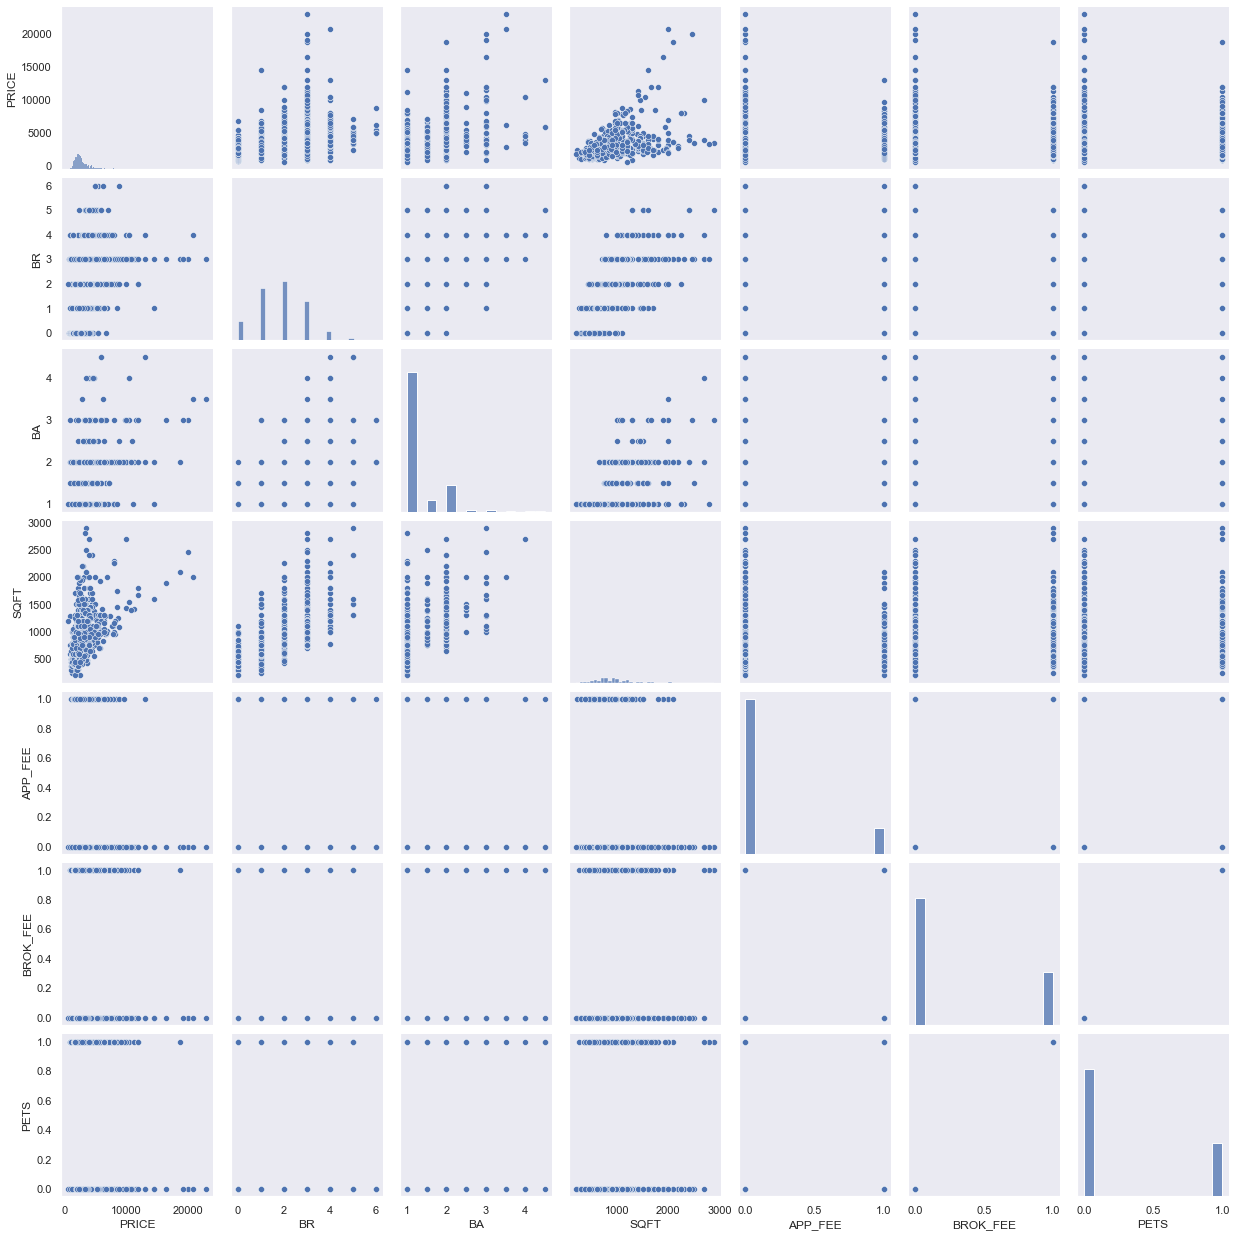

In [156]:
sns.pairplot(nyc)

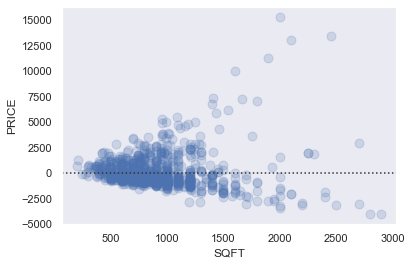

In [157]:
sns.residplot(x="SQFT", y="PRICE", data=nyc,
              scatter_kws={"s": 80, 'alpha' : 0.2});

Text(0.5, 1.0, 'Price by Borough')

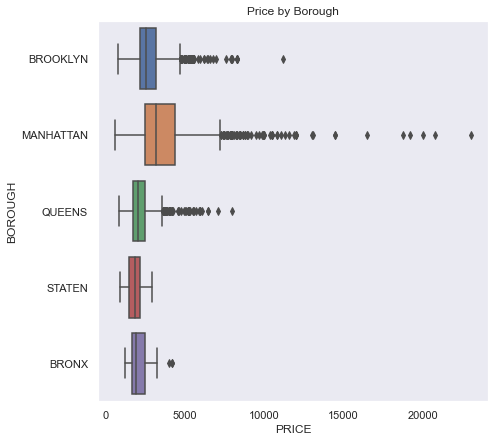

In [158]:
ax = plt.figure(figsize = (7,7))
ax = sns.boxplot(x="PRICE", y="BOROUGH", data=nyc, order=['BROOKLYN','MANHATTAN','QUEENS','STATEN','BRONX'])
ax.set_title('Price by Borough')

In [159]:
coefficients = pd.DataFrame()
coefficients['features'] = X8.columns
coefficients['coefficient_value'] =[(best_model.coef_[i]) for i in range(X8.shape[1])]
coefficients

,features,coefficient_value
0,BR,-175.852826
1,BA,639.468239
2,SQFT,92.929874
3,BROK_FEE,69.933919
4,WD_none,-342.004584
5,WD_on site,-148.601665
6,PARKING_off-street,93.727221
7,PARKING_valet,10.401695
8,BOROUGH_BROOKLYN,230.189344
9,BOROUGH_MANHATTAN,-260.720046


In [160]:
best_model.coef_

array([-175.8528265 ,  639.46823898,   92.92987366,   69.93391887,
       -342.00458444, -148.60166486,   93.72722088,   10.40169481,
        230.18934354, -260.72004579,   60.6293555 ,  -36.75253034,
       1004.94914031,  303.76861784])

Text(0.5, 1.0, 'Estimated Coefficients')

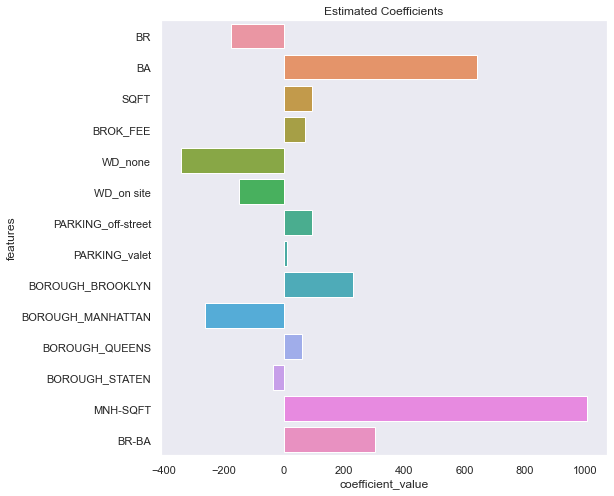

In [161]:
ax = plt.figure(figsize = (8,8))
ax = sns.barplot(x="coefficient_value", y="features", data=coefficients)
ax.set_title('Estimated Coefficients')

In [162]:
nycstudios = nyc.loc[nyc['BR'] == 0]
nycstudios['BA'].value_counts()

1.0    485
1.5      4
2.0      1
Name: BA, dtype: int64

In [163]:
nyc1bed = nyc.loc[nyc['BR'] == 1]
nyc1bed['BA'].value_counts()

1.0    1278
1.5      34
2.0      15
3.0       2
Name: BA, dtype: int64

In [164]:
nyc2bed = nyc.loc[nyc['BR'] == 2]
nyc2bed['BA'].value_counts()

1.0    1170
2.0     251
1.5      77
3.0       4
2.5       3
Name: BA, dtype: int64

In [165]:
nyc3bed = nyc.loc[nyc['BR'] == 3]
nyc3bed['BA'].value_counts()

1.0    568
2.0    265
1.5    122
3.0     25
2.5      8
3.5      1
4.0      1
Name: BA, dtype: int64

In [166]:
nyc4bed = nyc.loc[nyc['BR'] == 4]
nyc4bed['BA'].value_counts()

2.0    107
1.0     53
1.5     48
3.0     10
2.5      9
4.0      6
3.5      3
4.5      1
Name: BA, dtype: int64

In [167]:
nycbigbed = nyc.loc[nyc['BR'] > 4]
nycbigbed['BA'].value_counts()

2.0    31
1.5    11
2.5     7
3.0     5
4.5     2
1.0     2
Name: BA, dtype: int64